## nFeatures

build upon backToThe Trap


### Environment setup

##### pip install

In [5]:
!pip install tensorflow==2.1.0

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached tensorflow-2.1.0-cp37-cp37m-manylinux2010_x86_64.whl (421.8 MB)
  Using cached astor-0.8.1-py2.py3-none-any.whl (27 kB)
     |████████████████████████████████| 3.9 MB 4.6 MB/s eta 0:00:01
  Using cached gast-0.2.2-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.1.0-py2.py3-none-any.whl (448 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
     |████████████████████████████

In [6]:
!pip install numpy==1.19.5

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


##### versions

In [2]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.7.10 (default, Jun  4 2021, 14:48:32) 
[GCC 7.5.0]
Version info.
sys.version_info(major=3, minor=7, micro=10, releaselevel='final', serial=0)


In [1]:
import numpy
numpy.version.version

'1.19.5'

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


# LSTM applied to Stock Market data

### Goal
The main goal here is to __predict__ the next __BID CLOSE__.<br>
"*How much they will be paying for this active at the end of the next minute*"

## Specially on this notebook...
The goal here is to try to implement a solution with input_dimension != 1,<br>
and analyse its performance

### 1st Step

# Data Wrangling

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime

##  Data Ingestion

All data was extracted from Dukascopy Swiss Bank Group.
Dukascopy is a regulated bank that is authorised in two tier-1 jurisdictions (high trust), making it a safe broker (low-risk) for forex and CFDs trading. https://www.dukascopy.com/plugins/fxMarketWatch/?historical_data

In [226]:
bucket='bnr-bucket-01'
file_key = 'EURUSD_Candlestick_1_M_BID_06.03.2021-11.03.2021.csv'

s3uri = 's3://{}/{}'.format(bucket, file_key)

data = pd.read_csv(s3uri, header = 0)

In [227]:
data

,Gmt time,Open,High,Low,Close,Volume
0,07.03.2021 00:00:00.000,1.19128,1.19128,1.19128,1.19128,0.0
1,07.03.2021 00:01:00.000,1.19128,1.19128,1.19128,1.19128,0.0
2,07.03.2021 00:02:00.000,1.19128,1.19128,1.19128,1.19128,0.0
3,07.03.2021 00:03:00.000,1.19128,1.19128,1.19128,1.19128,0.0
4,07.03.2021 00:04:00.000,1.19128,1.19128,1.19128,1.19128,0.0
...,...,...,...,...,...,...
8635,12.03.2021 23:55:00.000,1.19476,1.19476,1.19476,1.19476,0.0
8636,12.03.2021 23:56:00.000,1.19476,1.19476,1.19476,1.19476,0.0
8637,12.03.2021 23:57:00.000,1.19476,1.19476,1.19476,1.19476,0.0
8638,12.03.2021 23:58:00.000,1.19476,1.19476,1.19476,1.19476,0.0


## Data Transformations

* Dropping undesireble columns
* Converting datatypes
* Defining index

In [228]:
data=data.drop(['Open', 'High', 'Low'], axis='columns', inplace=False)

In [229]:
def convertToTime(s):
    match = re.search(r'\d{2}.\d{2}.\d{4} \d{2}:\d{2}', s)
    s_substring = match.group()

    # Create date object in given time format yyyy-mm-dd
    #print(s_substring)
    s_datetime = datetime.strptime(s_substring, '%d.%m.%Y %H:%M')
    h=s_datetime.hour
    m=s_datetime.minute
    
    total_m = (int(h) *60)+m
    return total_m

data['dayMinute'] = data["Gmt time"].apply(lambda x: convertToTime(x))

In [230]:
def convertToDatetime(s):
    match = re.search(r'\d{2}.\d{2}.\d{4} \d{2}:\d{2}', s)
    s_substring = match.group()

    # Create date object in given time format yyyy-mm-dd
    s_datetime = datetime.strptime(s_substring, '%d.%m.%Y %H:%M')

    return s_datetime

data['Gmt time'] = data["Gmt time"].apply(lambda x: convertToDatetime(x))

In [231]:
data = data.rename(columns = {'Gmt time': 'datetime',
                              'Close': 'bidclose',
                              'dayMinute': 'dayMinute',
                              'Volume': 'volume'}, inplace = False)

data = data.set_index('datetime')

In [516]:
data

,bidclose,volume,dayMinute
datetime,,,
2021-03-07 22:00:00,1.19176,8.240,1320
2021-03-07 22:01:00,1.19177,15.730,1321
2021-03-07 22:02:00,1.19179,1.120,1322
2021-03-07 22:03:00,1.19178,60.290,1323
2021-03-07 22:04:00,1.19177,53.930,1324
...,...,...,...
2021-03-12 21:55:00,1.19510,135.540,1315
2021-03-12 21:56:00,1.19516,58.230,1316
2021-03-12 21:57:00,1.19531,458.650,1317


## Data Cleaning 

"*The FX market for the week begins at __9PM/10PM__ GMT on Sunday and closes at __9PM/10PM__ on Friday. Traders should be aware of the market timings in GMT, the DST shifts and their own timezone, in relation to the GMT, for them to fully grasp the forex market hours.*" https://www.fxempire.com/education/article/forex-trading-market-hours-408380

In [233]:
data = data.loc["2021-03-07 22:00:00":"2021-03-12 21:59:00"]

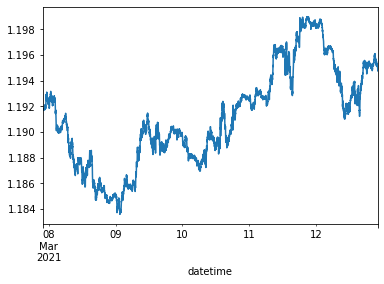

In [234]:
data['bidclose'].plot()

### 2st Step

# Data Preparation (LSTM Model)

In [235]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import numpy

## Create new Dataframe to preserve original data

In [517]:
df=data

## Splitting Dataset
Splitting dataset into train and test split
* train_data = first 96 hours (4 days) 
* test_data = last 24 hours

In [572]:
training_size=int(len(df)*0.8)
test_size=len(df)-training_size
train_data, test_data=df.iloc[0:training_size,:], df.iloc[training_size:len(df),:]

print("train_data size:"+str(len(train_data)))
print("test_data size:"+str(len(test_data)))

train_data size:5760
test_data size:1440


In [238]:
df.iloc[0:training_size,:]

,bidclose,volume,dayMinute
datetime,,,
2021-03-07 22:00:00,1.19176,8.24,1320
2021-03-07 22:01:00,1.19177,15.73,1321
2021-03-07 22:02:00,1.19179,1.12,1322
2021-03-07 22:03:00,1.19178,60.29,1323
2021-03-07 22:04:00,1.19177,53.93,1324
...,...,...,...
2021-03-11 21:55:00,1.19840,39.83,1315
2021-03-11 21:56:00,1.19844,21.36,1316
2021-03-11 21:57:00,1.19844,27.33,1317


In [239]:
#BACKUP of slipts in UnNormalizedForm
train_data_unf = train_data
test_data_unf = test_data

## Normalize Data

__LSTM__ are sensitive to the scale of the data. <br>
So we need to apply MinMax scaler.<br>
<br>

Not only do you need normalisation on test data, but you should apply the exact same scaling as for your training data.<br>
Note that for test, you only need to scaler.transform()
```python
scaler = StandardScaler()
train_X = scaler.fit_transform( train_X )
test_X = scaler.transform( test_X )
```
(https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well) 


In [319]:
train_data.shape[1]

3

In [318]:
scaler=MinMaxScaler(feature_range=(0,1))
train_data=scaler.fit_transform(np.array(train_data).reshape(-1,train_data.shape[1]))

In [374]:
b=scaler.inverse_transform(train_data)

In [375]:
train_data.shape

(5760, 3)

In [176]:
scaler_a=MinMaxScaler(feature_range=(0,1))
scaler_b=MinMaxScaler(feature_range=(0,1))
scaler_c=MinMaxScaler(feature_range=(0,1))
a=scaler.fit_transform(np.array(train_data)[:,0])

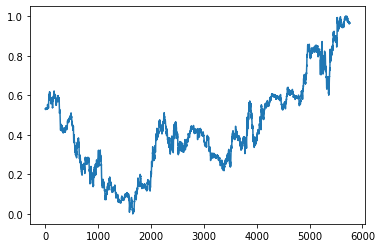

In [49]:
#Checking if bidclose feature was stored correclty
c=[]

for i in train_data:
    c.append(i[0])
    
plt.plot(c)

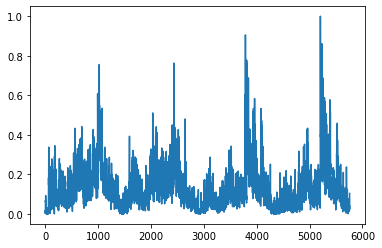

In [50]:
#Checking if volume feature was stored correclty
c=[]

for i in train_data:
    c.append(i[1])
    
plt.plot(c)

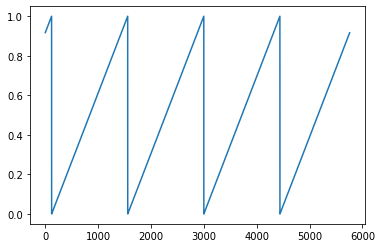

In [51]:
#Checking if timeMinute feature was stored correclty
c=[]

for i in train_data:
    c.append(i[2])
    
plt.plot(c)

In [52]:
train_data

array([[0.53116883, 0.00922226, 0.91730368],
       [0.53181818, 0.01760512, 0.91799861],
       [0.53311688, 0.00125351, 0.91869354],
       ...,
       [0.96493506, 0.03058792, 0.9152189 ],
       [0.96883117, 0.03322925, 0.91591383],
       [0.96493506, 0.10367212, 0.91660876]])

In [53]:
len(train_data)

5760

In [569]:
test_data.shape[1]

1

In [573]:
test_data=scaler.transform(np.array(test_data).reshape(-1,test_data.shape[1]))

In [574]:
test_data

array([[0.93571429, 0.03396792, 0.91730368],
       [0.94805195, 0.01175167, 0.91799861],
       [0.95714286, 0.00167881, 0.91869354],
       ...,
       [0.76168831, 0.51332416, 0.9152189 ],
       [0.74805195, 0.35086011, 0.91591383],
       [0.72597403, 0.10255851, 0.91660876]])

## Create Matrix Dataset
Create x_inputs and y_outputs from (train and test dataset) to be ingest by LSTM Model<br>

Convert an array of values into a dataset matrix

In [134]:
def create_dataset(dataset, time_step=1):
    dataX=[]
    dataY=[]
    currentX=[]
    
    for i in range(len(dataset)):
        if(i>=time_step):
            a=dataset[i-time_step:i]
            dataX.append(a)
            dataY.append(dataset[i])
    
    return numpy.array(dataX), numpy.array(dataY)

In [135]:
##Create x_inputs and y_outputs from (train and test dataset) to be ingest by LSTM Model
##Following this fashion
##Example:

a=[0,1,2,3,4,5,6]
#a=np.array(a).reshape(-1,1)  __probably not needed
time_step=3
create_dataset(a,time_step)

(array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]]),
 array([3, 4, 5, 6]))

In [136]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

y_train=y_train[:,0]
y_test=y_test[:,0]

In [139]:
print("x_train.shape: "+str(x_train.shape))
print("y_train.shape: "+str(y_train.shape))

print("x_test.shape: "+str(x_test.shape))
print("y_test.shape: "+str(y_test.shape))

x_train.shape: (5660, 100, 3)
y_train.shape: (5660,)
x_test.shape: (1340, 100, 3)
y_test.shape: (1340,)


## Reshape [sample, time_steps, features]
Reshape input to be [sample, time_steps, features] witch is __required for LSTM__<br>
Only if needed, your data might be already on the expected shape

In [26]:
#nFeatures = 1

#x_train= x_train.reshape(x_train.shape[0],x_train.shape[1],nFeatures)
#x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],nFeatures)

## Create validation dataset

_"Suppose that we would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. The __validation set__ approach […] is a very simple strategy for this task. It involves randomly __dividing the available set of observations into two parts__, a training set and a validation set or hold-out set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate — typically assessed using MSE in the case of a quantitative response—provides an estimate of the test error rate."_ — Gareth James

– __Training set__: A set of examples used for learning, that is to fit the parameters of the classifier.

– __Validation set__: A set of examples used to tune the parameters of a classifier, for example to choose the number of hidden units in a neural network.

– __Test set__: A set of examples used only to assess the performance of a fully-specified classifier.

##### currently, validation is been set as a parameter of *model.fit()*


### 3st Step

# Long Short Term Memory

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## Create the Stacked LSTM model

In [140]:
model = Sequential()
model.add(LSTM(15,return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(15,return_sequences=True))
model.add(LSTM(15))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [141]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 15)           1140      
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 15)           1860      
_________________________________________________________________
lstm_5 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 4,876
Trainable params: 4,876
Non-trainable params: 0
_________________________________________________________________


## Train the Stacked LSTM model

__BATCH:__ The __batch__ size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.<br>
__EPOCH:__ The number of __epochs__ is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

* __Batch Gradient Descent.__ Batch Size = Size of Training Set
* __Stochastic Gradient Descent.__ Batch Size = 1
* __Mini-Batch Gradient Descent.__ 1 < Batch Size < Size of Training Set

In [144]:
history = model.fit(x_train,y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    verbose=1)

Train on 4528 samples, validate on 1132 samples
Epoch 1/100
4528/4528 [==============================] - 13s 3ms/sample - loss: 0.0130 - val_loss: 0.0147
Epoch 2/100
4528/4528 [==============================] - 8s 2ms/sample - loss: 8.5696e-04 - val_loss: 0.0081
Epoch 3/100
4528/4528 [==============================] - 8s 2ms/sample - loss: 6.6907e-04 - val_loss: 0.0060
Epoch 4/100
4528/4528 [==============================] - 8s 2ms/sample - loss: 6.0537e-04 - val_loss: 0.0042
Epoch 5/100
4528/4528 [==============================] - 8s 2ms/sample - loss: 5.6471e-04 - val_loss: 0.0037
Epoch 6/100
4528/4528 [==============================] - 8s 2ms/sample - loss: 5.1707e-04 - val_loss: 0.0027
Epoch 7/100
4528/4528 [==============================] - 8s 2ms/sample - loss: 4.9381e-04 - val_loss: 0.0020
Epoch 8/100
4528/4528 [==============================] - 8s 2ms/sample - loss: 4.6426e-04 - val_loss: 0.0023
Epoch 9/100
4528/4528 [==============================] - 9s 2ms/sample - loss: 4.39

## Learning Curve

These plots can help to diagnose whether the model has over learned, under learned, or is suitably fit to the training dataset.
https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

#### OBS:
Note that what was printed above as "loss", actually refers to cost_function
<br>
<br>
* One __EPOCH__ is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.<br>
* The __COST_FUNCTION__ (Results from whole trainining data_set samples analysis)<br>
It is a single value that measures how bad was the model at particular EPOCH, by calculating the mean between all LOSS_FUNCTIONS.<br>
* The __LOSS_FUNCTION__ (Results from one single training sample analysis)<br>
It is the cost of a single training example. Difference between values predicted and the actuals outputs expected. (usually: Mean Squared Error)
* The __OPTIMIZERS__<br>
Once we have the COST_FUNCTION of an Epoch, we can apply __OPTIMIZERS__ in order to reduce its value, and therefore find a minimal COST<br>

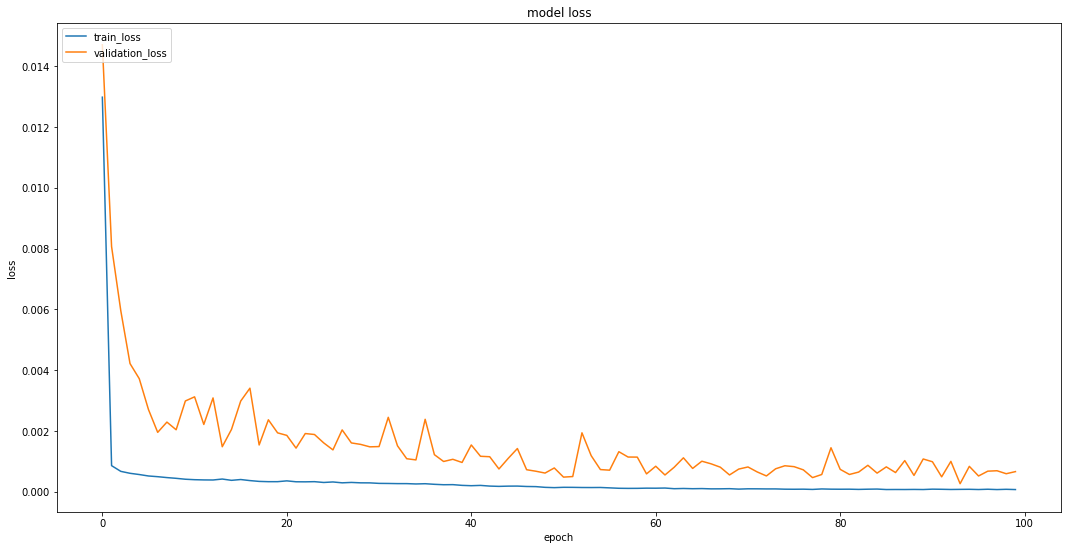

In [145]:
plt.figure(figsize = (18,9))
##plt.xlim(3500,4500)
##plt.ylim(0,0.0002)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'validation_loss'], loc='upper left')

plt.show()

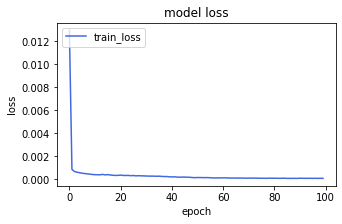

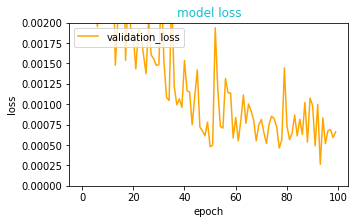

In [146]:
plt.figure(figsize = (5,3))
##plt.xlim(3500,4500)
##plt.ylim(0,0.0003)


plt.plot(history.history['loss'],color='royalblue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss'], loc='upper left')

plt.show()

plt.figure(figsize = (5,3))
#plt.xlim(3500,4500)
plt.ylim(0,0.002)

plt.plot(history.history['val_loss'],color='orange')
plt.title('model loss',color='C9')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation_loss'], loc='upper left')

plt.show()


In [147]:
print("train loss= "+str(history.history['loss'][-1]))
print("val loss= "+str(history.history['val_loss'][-1]))

train loss= 7.040005957509486e-05
val loss= 0.0006610237349107756


### 4st Step

# Predictions

## model.predict()

In [481]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

## Dataset back to original format

In [462]:
def toScalerShape(prediction, nFeatures):
    originalShape = prediction
    for i in range(nFeatures-1):      
        prediction=concatenate((prediction,originalShape),axis=(1))
    
    return prediction_scalerShape

In [468]:
def extarctPredict(prediction_scalerShape):
    return prediction_scalerShape[:,0]

In [466]:
prediction_scalerShape = toScalerShape(test_predict, 3)

In [471]:
inv_test_predict=scaler.inverse_transform(prediction_scalerShape)

In [472]:
test_predict = extarctPredict(inv_test_predict)

In [473]:
test_predict.shape

(1340,)

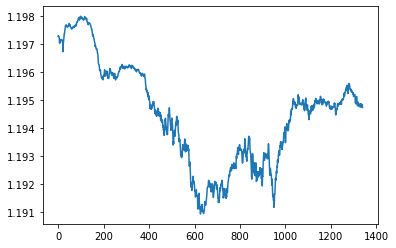

In [477]:
plt.plot(test_predict)

In [425]:
print("x_test.shape: "+str(x_test.shape))
x_testSlice=x_test[:, -1:, :]
print("x_testSlice.shape: "+str(x_testSlice.shape))

x_test.shape: (1340, 100, 3)
x_testSlice.shape: (1340, 1, 3)


In [426]:
x_test_scalerShape = x_testSlice.reshape(x_testSlice.shape[0],x_testSlice.shape[2])
print("x_test_scalerShape.shape: "+str(x_test_scalerShape.shape))

x_test_scalerShape.shape: (1340, 3)


In [429]:
print("test_predict.shape: "+str(test_predict.shape))
test_predictReshaped = test_predict.reshape(test_predict.shape[0])
print("test_predictReshaped.shape: "+str(test_predictReshaped.shape))
print("x_test_scalerShape[:,0] = test_predictReshaped: ")
print(str(x_test_scalerShape[:,0].shape) +"="+ str(test_predictReshaped.shape))
x_test_scalerShape[:,0] = test_predictReshaped


test_predict.shape: (1340, 1)
test_predictReshaped.shape: (1340,)
x_test_scalerShape[:,0] = test_predictReshaped: 
(1340,)=(1340,)


https://stackoverflow.com/questions/57216718/how-to-inverse-transform-the-predicted-values-in-a-multivariate-time-series-lstm

In [659]:
def featured_inverseTransform(singleDimensionData, nFeatures):
    if type(singleDimensionData)==list:
        singleDimensionData = np.array(singleDimensionData)
    
    if len(singleDimensionData.shape)==1:
        singleDimensionData = singleDimensionData.reshape(-1,1)
    scalerShape_data = toScalerShape(singleDimensionData, nFeatures)
    inverseTransform_data=scaler.inverse_transform(scalerShape_data)
    inv_singleDimensionData = extarctPredict(inverseTransform_data)
    
    return inv_singleDimensionData

In [ ]:
nFeatures = 3
prediction_scalerShape = toScalerShape(train_predict, nFeatures)
inv_train_predict=scaler.inverse_transform(prediction_scalerShape)
train_predict = extarctPredict(inv_test_predict)

In [485]:
train_predict = featured_inverseTransform(train_predict, 3)
test_predict = featured_inverseTransform(test_predict, 3)

In [504]:
y_train = featured_inverseTransform(y_train, 3)
y_test = featured_inverseTransform(y_test, 3)

## Print prediction performance metrics

In [505]:
import math
from sklearn.metrics import mean_squared_error

In [506]:
print("train loss= "+str(history.history['loss'][-1]))
print("val loss= "+str(history.history['val_loss'][-1]))

train loss= 7.040005957509486e-05
val loss= 0.0006610237349107756


In [507]:
print("train loss RMSE= "+str(math.sqrt(history.history['loss'][-1])))
print("val loss RMSE= "+str(math.sqrt(history.history['val_loss'][-1])))

train loss RMSE= 0.008390474335524473
val loss RMSE= 0.025710381850738345


In [508]:
trainMSE = (mean_squared_error(train_predict,y_train))
print("Train MSE= "+str(trainMSE))

testMSE = (mean_squared_error(test_predict,y_test))
print("Test MSE= "+str(testMSE))

Train MSE= 4.367515088245822e-08
Test MSE= 1.4290955608531668e-07


In [509]:
trainMSE = math.sqrt(mean_squared_error(train_predict,y_train))
print("Train RMSE= "+str(trainMSE))

testMSE = math.sqrt(mean_squared_error(test_predict,y_test))
print("Test RMSE= "+str(testMSE))

Train RMSE= 0.000208986006427364
Test RMSE= 0.0003780338028342395


# Comeco a bagunca, PLOTING

In [519]:
df=df.drop(['volume', 'dayMinute'], axis='columns', inplace=False)

In [524]:
train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

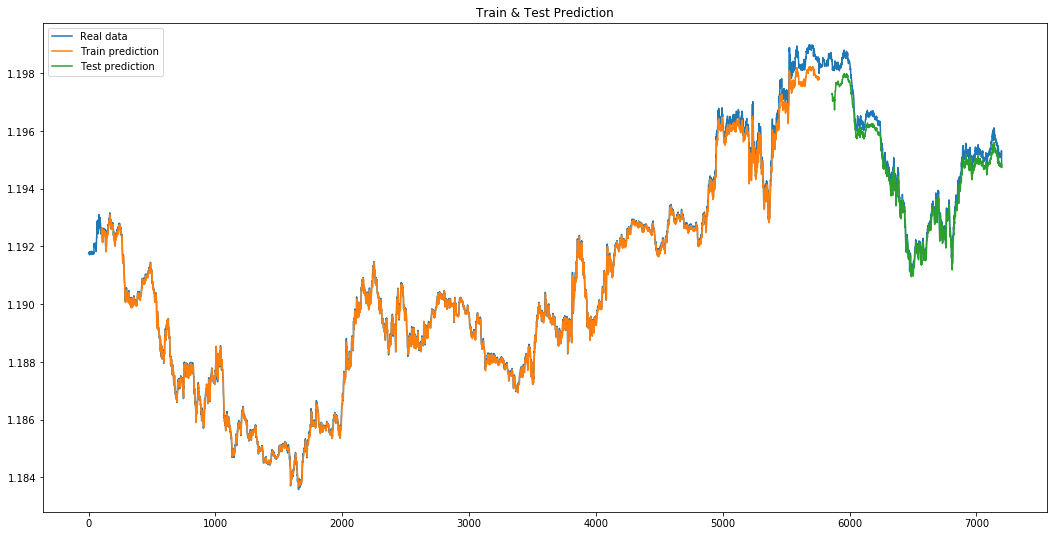

In [525]:
## Plotting 
# shift train predictions for plotting

plt.figure(figsize = (18,9))
#plt.xlim(6500,6560)
#plt.ylim(3.5, 6)

look_back=time_step
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:,:]=np.nan

initialx_train=look_back
finalx_train=initialx_train+len(train_predict)

trainPredictPlot[initialx_train:finalx_train,:]=train_predict

# shift test predictions for plotting 
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:,:]=numpy.nan

#initialx_test=finalx_train+(look_back)
initialx_test=len(train_data)+(look_back) 
finalx_test=initialx_test+len(test_predict)

testPredictPlot[initialx_test:finalx_test,:]=test_predict

plt.title('Train & Test Prediction')

# plot baseline and predictions 
plt.plot(df.values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Real data','Train prediction','Test prediction'], loc='upper left')


plt.show()

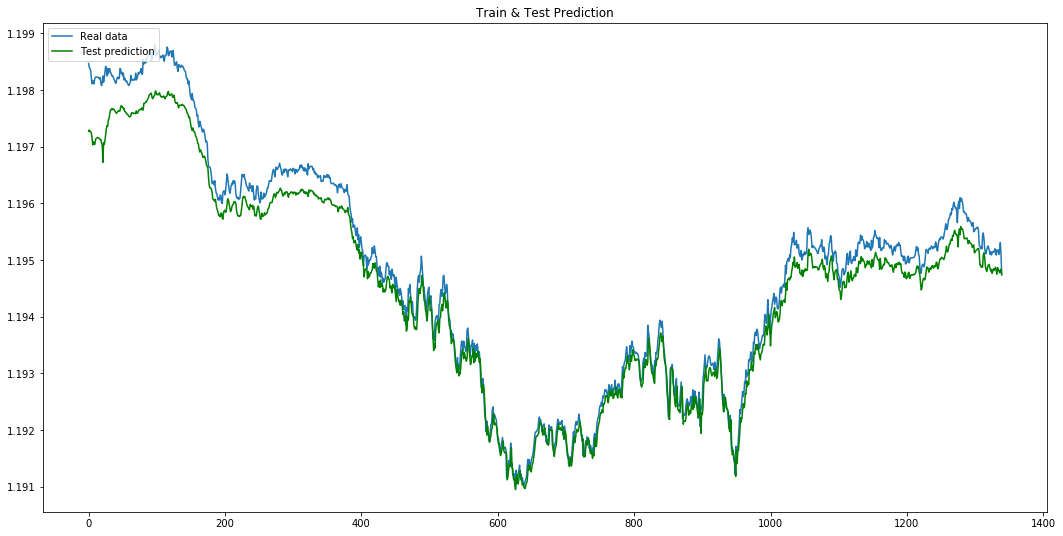

In [526]:
## Plotting 
# shift train predictions for plotting

plt.figure(figsize = (18,9))
#plt.xlim(6500,6560)
#plt.ylim(3.5, 6)

look_back=time_step
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:,:]=np.nan

initialx_train=look_back
finalx_train=initialx_train+len(train_predict)

trainPredictPlot[initialx_train:finalx_train,:]=train_predict

# shift test predictions for plotting 
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:,:]=numpy.nan

#initialx_test=finalx_train+(look_back)
initialx_test=len(train_data)+(look_back) 
finalx_test=initialx_test+len(test_predict)

testPredictPlot[initialx_test:finalx_test,:]=test_predict

plt.title('Train & Test Prediction')

# plot baseline and predictions 
plt.plot(y_test)
plt.plot(test_predict,color='green')
#plt.plot(testPredictPlot)
plt.legend(['Real data','Test prediction','Test prediction'], loc='upper left')


plt.show()

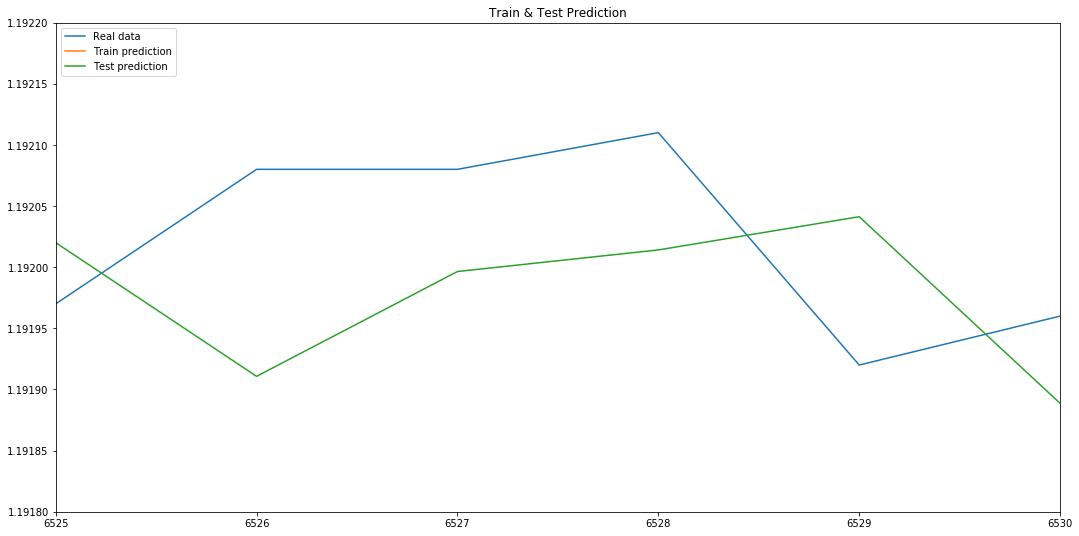

In [527]:
## Plotting 
# shift train predictions for plotting

plt.figure(figsize = (18,9))
plt.xlim(6525,6530)
plt.ylim(1.1918, 1.1922)## Plotting 
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = numpy.empty_like(df)
trainPredictPlot[:,:]=np.nan

initialx_train=look_back
finalx_train=initialx_train+len(train_predict)

trainPredictPlot[initialx_train:finalx_train,:]=train_predict

# shift test predictions for plotting 
testPredictPlot = numpy.empty_like(df)
testPredictPlot[:,:]=numpy.nan

#initialx_test=finalx_train+(look_back)
initialx_test=len(train_data)+(look_back) 
finalx_test=initialx_test+len(test_predict)

testPredictPlot[initialx_test:finalx_test,:]=test_predict

plt.title('Train & Test Prediction')

# plot baseline and predictions 
plt.plot(df.values)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Real data','Train prediction','Test prediction'], loc='upper left')


plt.show()

In [733]:
def predictLSTM(n_days, predict_position, xAxix_zoomOut=0.001, yAxix_zoomOut=0.001):

    print("len(test_data): "+str(len(test_data)))

    # create x_input from test_data reshaped
    #x_input=test_data[predict_position-time_step:predict_position].reshape(1,-1)
    x_input=test_data[predict_position-time_step:predict_position]
    print("x_input.shape: "+str(x_input.shape))

    # create temp_input from x_input
    temp_input=list(x_input[:,0])
    #temp_input=temp_input[0].tolist()


    # demonstrate prediction for next 10 days
    from numpy import array

    lst_output=[]
    n_steps=100
    i=0
    
    x_input = x_input.reshape((1, x_input.shape[0],x_input.shape[1]))

    while(i<n_days):
        if(len(temp_input)>time_step):
            temp_input=temp_input[1:]
            x_input=np.array(temp_input)
            x_input=x_input.reshape(-1,1)
            original = x_input
            x_input = concatenate((original,x_input),axis=1)
            x_input = concatenate((original,x_input),axis=1)
            
            #print(x_input)
            #x_input=x_input.reshape(1,-1)
            
            #x_input = x_input.reshape((1, x_input.shape[0],x_input.shape[1]))
            
            x_input = x_input.reshape((1, x_input.shape[0],x_input.shape[1]))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            
            i=i+1
        else:
            print(x_input.shape)
            #x_input = x_input.reshape((1, x_input.shape[0],x_input.shape[1]))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            
            i=i+1

    print("len(lst_output):"+str(len(lst_output)))
    
    day_new=np.arange(1,test_size)
    day_pred=np.arange((predict_position+1),(predict_position+1+n_days))

    print("len(df):"+str(len(df)))

    #plt.figure(figsize = (18,9))
    #plt.xlim(1325,1340)
    #plt.ylim(1.194, 1.196)
    
    xa,xb=(predict_position,predict_position+n_days)
    ya,yb=(min(test_data_unf["bidclose"][xa:xb].values),max(test_data_unf["bidclose"][xa:xb].values))
    plt.figure(figsize = (18,9))
    
    plt.xlim(xa*(1-xAxix_zoomOut),xb*(1+xAxix_zoomOut))
    plt.ylim(ya*(1-yAxix_zoomOut),yb*(1+yAxix_zoomOut))

    plt.plot(day_new,df[len(df)-len(day_new):len(df)],color='royalblue')
    
    lst_output = featured_inverseTransform(lst_output, 3)
    plt.plot(day_pred,lst_output,color='green')
    
    plt.legend(['Real data','Test prediction'], loc='upper left')
    

len(test_data): 1440
x_input.shape: (100, 3)
(1, 100, 3)
len(lst_output):60
len(df):7200


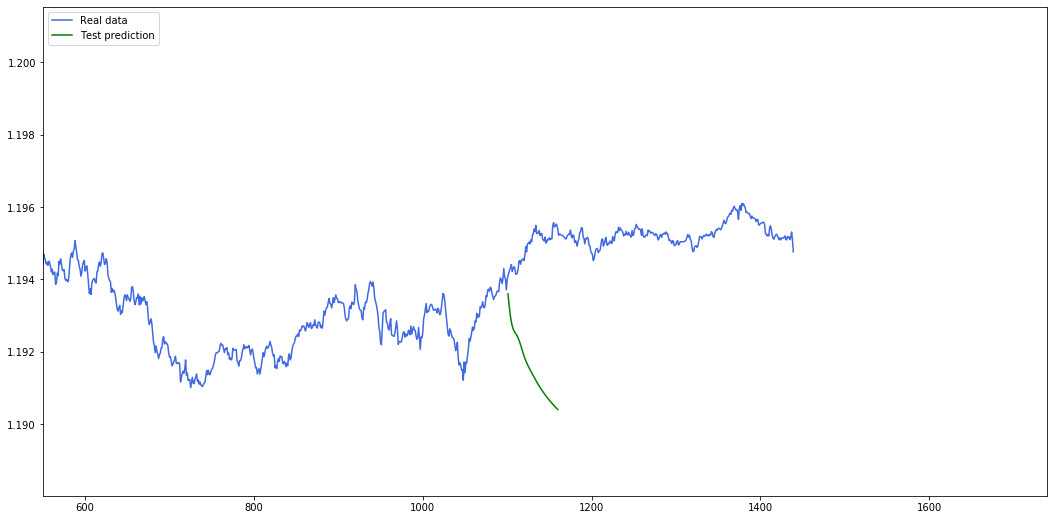

In [738]:
##30 days prediction goes pretty well !!
predictLSTM(n_days = 60,
            predict_position = 1100,
            xAxix_zoomOut = 0.5,
            yAxix_zoomOut = 0.005) 